In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../scripts")
import models
import pickle
from Bio import SeqIO
from main import *
import random
from update_state_assignments import *

## Load Data & Generate batches

In [111]:
data = load_data("../data/GM12878_10k", "../data/loop_sequences_GM12878.fasta", "../data/epigenomic_tracks/GM12878.pickle", test=True)
seq_length = 100
spacing = 50
batch_size = 5

# Generate a random batch of data
indexes = np.random.choice(len(data), size=(batch_size,), replace=False)
batch = [data[i] for i in indexes]
X, ranges = generate_X(batch, seq_length=seq_length, spacing=spacing)

Reading histone data...
Reading sequence data...
Reading Hi-C data...
Sequence object not found for sequence 10:49865000:50015000
Sequence object not found for sequence 10:50620000:50725000
Sequence object not found for sequence 10:52190000:52270000
Sequence object not found for sequence 10:54070000:54250000
Sequence object not found for sequence 10:54400000:54550000
Sequence object not found for sequence 10:54405000:54485000
Sequence object not found for sequence 10:5485000:5625000
Sequence object not found for sequence 10:5485000:5670000
Sequence object not found for sequence 10:56850000:57030000
Sequence object not found for sequence 10:59945000:60050000
Sequence object not found for sequence 10:6055000:6130000
Sequence object not found for sequence 10:60710000:61005000
Sequence object not found for sequence 10:60710000:60940000
Sequence object not found for sequence 10:61385000:61570000
Sequence object not found for sequence 10:6150000:6245000
Sequence object not found for sequence

## Methods of Initializing R

In [64]:
def initial_R_random(n_labels, bound=7):
    return np.random.random(size=(n_labels, n_labels)) * bound

In [74]:
def initial_R_random_diagonal(n_labels, diag_bound=7, ndiag_bound = 5):
    R = np.random.random(size=(n_labels, n_labels)) * ndiag_bound
    np.fill_diagonal(R, 0)
    R += np.diag(np.random.random(size=n_labels)*(diag_bound-ndiag_bound)+ndiag_bound)
    return R

In [66]:
def initial_R_nested_asgn(n_labels):
    """
    Generates an random initial R matrix of dimension n_labels x n_labels given
    the data.

    data: a list of tuples (Sequence, InteractionMatrix) as generated from
        load_data.
    batch_size: the number of elements of data to select randomly to use in this
        iteration.
    """
    if int(np.log2(n_labels)) == np.log2(n_labels):
        # Build a hierarchical matrix
        R = np.zeros((1, 1))
        scales = int(np.log2(n_labels))
        for i in range(scales):
            R = np.repeat(np.repeat(R, 2, axis=0), 2, axis=1)
            R += np.diag(np.random.randint(4.0, 6.0, size=2 ** (i + 1)) / scales)
            R += (np.random.random(size=R.shape) * 2.0 + 1.0) / scales
#             print(i, R)
        return R
    else:
        R = np.diag(np.random.randint(2.0, 4.0, size=n_labels))
        return R + np.random.random(size=(n_labels, n_labels)) * 2.0 + 1.0


In [104]:
def initial_R_diagonal_setting(data, n_labels, batch_size=10, bound=0.25):
    """
    Generates an random initial R matrix of dimension n_labels x n_labels given
    the data.

    data: a list of tuples (Sequence, InteractionMatrix) as generated from
        load_data.
    batch_size: the number of elements of data to select randomly to use in this
        iteration.
    """
    def shear_matrix(ssm):
        # Each column shifts one more down
        new_ssm = np.zeros(ssm.shape)
        for n in range(ssm.shape[0]):
            new_ssm[:,n] = np.roll(ssm[:,n], -n)
        return new_ssm

    batch_H = [shear_matrix(data[i][1].values_grid()) for i in range(batch_size)]

    diagonal_avg = 0.0
    off_diagonal_avg = 0.0
    for i, H in enumerate(batch_H):
        bound_len = int(bound*H.shape[0])
        diagonal_avg += np.average(np.concatenate((H[:bound_len//2,:], H[H.shape[0] - bound_len//2:,:])))
        off_diagonal_avg += np.average(H[bound_len//2:H.shape[0] - bound_len//2,:])

    diagonal_avg /= len(batch_H)
    off_diagonal_avg /= len(batch_H)
    
    print(diagonal_avg, off_diagonal_avg)

    R = np.full((n_labels,n_labels), off_diagonal_avg, dtype=float)
    np.fill_diagonal(R, diagonal_avg)
    return R

## Run DP using different init methods

6.669033913725526 5.105723024102265


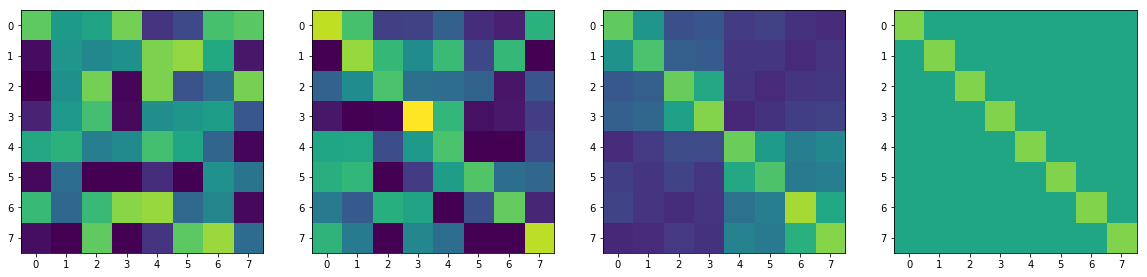

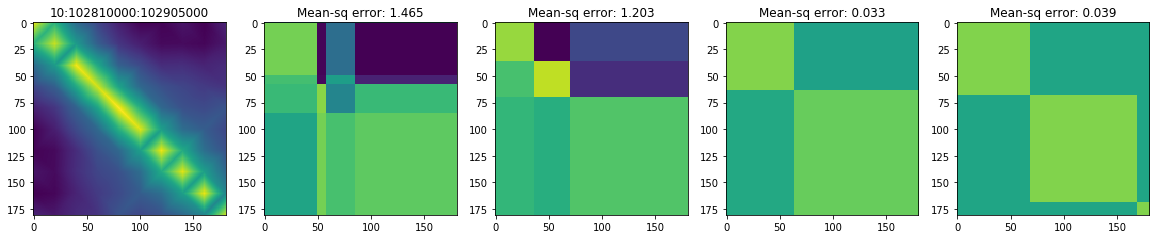

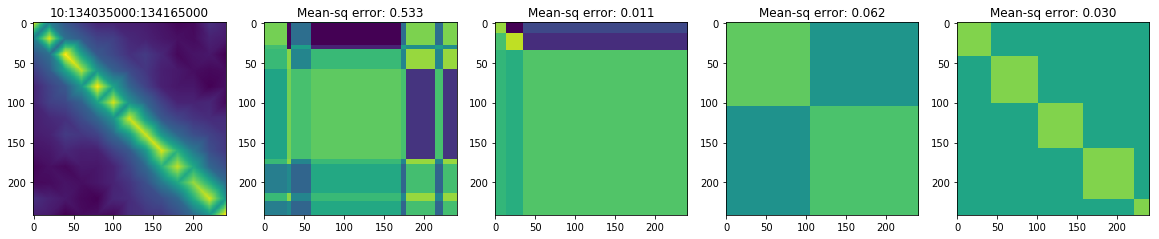

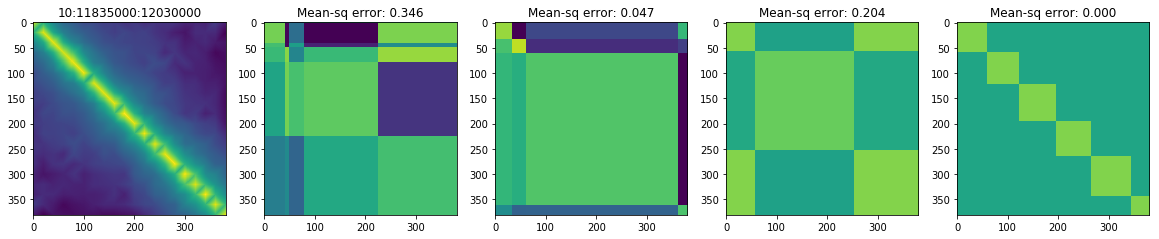

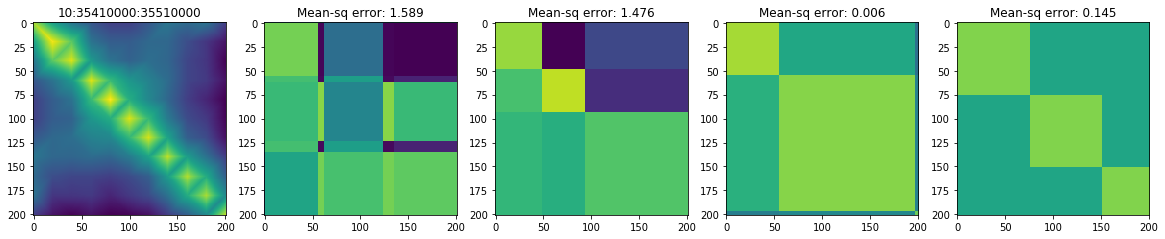

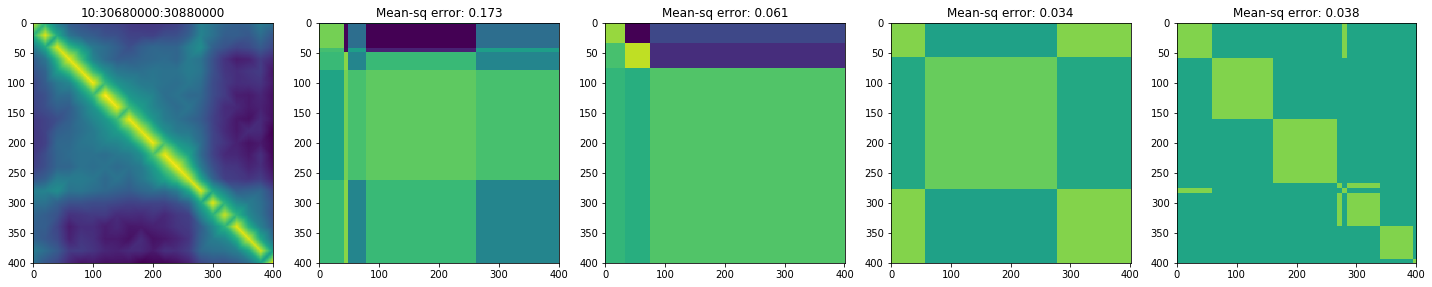

In [112]:
# Run DP algorithm
coarse_spacing = spacing * 10 
n_labels = 8

Rs = []
Rs.append(initial_R_random(n_labels))
Rs.append(initial_R_random_diagonal(n_labels, diag_bound=8, ndiag_bound = 6))
Rs.append(initial_R_nested_asgn(n_labels))
Rs.append(initial_R_diagonal_setting(data, n_labels, batch_size=batch_size))

plt.figure(figsize=(20,5))
for i, R in enumerate(Rs):
    plt.subplot(1,len(Rs),i+1)
    plt.imshow(R, vmin=1, vmax=8)
plt.show()

for i, (_, H) in enumerate(batch):
    #plot H
    plt.figure(figsize=(20,5))
    plt.subplot(1, len(Rs)+1, 1)
    plt.imshow(H.values_grid(coarse_spacing))
    plt.title(H.identifier)
    
    for j, R in enumerate(Rs): 
        #print(H.identifier)
        score, path = state_asg(H, R, normalized_diff, penalty, coarse_spacing, None)
        pred = predicted_matrix_worker(path, R)
        
        #plot R
        plt.subplot(1,len(Rs)+1,j+2)
        plt.imshow(pred, vmin=1, vmax=8)
        plt.title("Mean-sq error: %.3f" %(np.nanmean(pred)-np.nanmean( H.values_grid(coarse_spacing)))**2 )
        
plt.tight_layout()
plt.show()